The process can be defined from ($\varphi, \lambda, Q$) where
* $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
* $\lambda$ is the probability that a jumps occurs during the particle's movement
* $Q$ is the Markov kernel used for the jump

ZigZag sampler:

* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution: $$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
Notations:
$$ s_{\theta}(x, R v, t) = \begin{pmatrix} s_{\theta}(x, R_1 v, t)_1 \\ \cdots \\ s_{\theta}(x, R_d v, t)_d \end{pmatrix}$$
where $R_i v = \begin{pmatrix} v_1 \\ \cdot \\ -v_i \\ \cdot \\ v_n \end{pmatrix}$
* Fit the model by minimizing:
     $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



Current Limitations
* If the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$
* The loss is unstable.

**Symmetrised ratio matching** we introduce the function $g(r) = \frac{1}{1+r}$ and define the objective function
\begin{equation}
    J_{ERM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \left(g(s_\theta(X_t,V_t,t)[i]) - g(r_i(X_t,V_t,t)) \right)^2 + \left(g(s_\theta(X_t,R_iV_t,t)[i]) - g(r_i(X_t,R_iV_t,t)) \right)^2 \right]
\end{equation}
which is equivalent, as an objective function, to:
\begin{equation}
    J_{IRM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \frac{1}{(1 + s_\theta(x,v,t)[i])^2} +\frac{1}{(1 + s_\theta(x,R_i v,t)[i])^2}  - \frac{2}{1 + s_\theta(x,v,t)[i]}\right]
\end{equation}


**KL minimisation** Focus on the score entropy:
\begin{equation}
    J_{ERM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -r_i(X_t,V_t,t)  - \Big( \log s_\theta(X_t,R_iV_t,t)[i]) - \log r_i(X_t,R_iV_t,t)\Big) \right].
\end{equation}
where $\{w_i\}$ is a sequence of weights. Also this objective function considers the error in the estimation of both $r_i(x,v,t)$ and $r_i(x,R_iv,t)$, encouraging stable solutions. Clearly the implicit formulation has objective function 
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -  \log s_\theta(X_t,R_iV_t,t)[i]) \right].
\end{equation}

Question: shouldn't it be
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] +  \log s_\theta(X_t,R_iV_t,t)[i]) \right] \quad ?
\end{equation}

TODO:
* Mixing time of pdmp (time horizon?). (Andrea)
* Dimension problem. Think of it today: first architecture is outputting (Dario)
$$r_t(x, v)_1, r_t(x, R_1v)_1, \cdots$$ 
Second one: (Dario)
$$r_t(x, 1, v_{[2:d]})_1, r_t(x, -1, v_{[2:d]})_1, \cdots$$
Third one: (Andrea)
Coordinate descent on the loss 
* Monte-Carlo to plot real density ratio, compare with model. (Dario)
* Add evaluation metrics, and loss metrics. (Dario)
* Experiments: 
    * Other datasets. $\mathcal{N}(\mu, \sigma^2 I_2)$ instead of mixture. (Dario).
    * Increase dimensions of the data distribution (Dario).
    * Study effect of the number of reverse steps. Effect of the backward sampling (spliting scheme) (Andrea)


Connect to github, maybe andrea has his own branch, and then you can update the code. 


* Architecture. Change the network architecture. Receives $R$ as an argument, and is made invariant on speed?
    $$ s_{\theta}(x, v, R) : \quad  s_{\theta}(x, Rv, R) = s_{\theta}(x, v, R)$$ 
    Take the component $i$ as an input. Idea of copula? Take a single dimension as input too? outputs a single value.

# PDMP

## Setup

* Prepare all our objects

In [4]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 2,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-3, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.PDMP(time_horizon = 8, reverse_steps = 200, device=device)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)


0


In [5]:
# can use this to load a model, optimizer, learning schedule, and eval metrics

MODEL_PATH = 'models/model.pt'
EVAL_PATH = 'models/eval_model.pt'

manager.load(MODEL_PATH)
manager.load_eval_metrics(EVAL_PATH)

## Look at the noised data

In [204]:
# clone data, since it will be modified by forward process
data_clone = GMM2.clone()
# orint its shape
print(data_clone.shape)
# get a unit time horizon
time_horizons = torch.ones(data_clone.shape) 
for i in range(int(pdmp.T)):
    t = time_horizons.clone()
    pdmp.forward(data_clone, t)
#* pdmp.T
# forward process for pmdp.T time units
#pdmp.forward(data_clone, time_horizons)

torch.Size([32768, 1, 2])


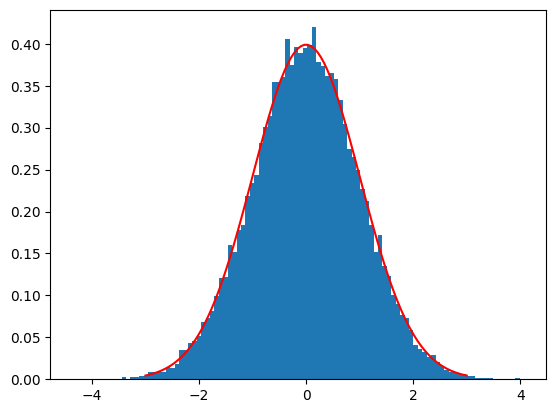

In [207]:
# look at histogram of one component at the last timestep

pos = data_clone.squeeze(1) # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

* Still need some work to get to the Monte-Carlo estimation for every possible values of speed.

In [9]:
# clone data, since it will be modified by forward process
M = 1
L = []
lims = 3
T = np.linspace(0, 5, 100)
for t in T:
    # Define the number of bins in each dimension
    num_bins = 100  # You can adjust this value as needed
    tmp = []
    for m in range(M):
        data_clone = GMM2.clone()
        pdmp.forward(data_clone, torch.ones(data_clone.shape)*t)
        data_clone = data_clone.clamp(-lims, lims).squeeze(1).numpy()
        # Compute the 2D histogram
        hist, x_edges, y_edges = np.histogram2d(data_clone[:,0], data_clone[:,1], bins=num_bins, range=[[-lims, lims], [-lims, lims]], density=True)
        tmp.append(hist)
        # 'hist' contains the 2D histogram values
        # 'x_edges' and 'y_edges' are the bin edges in the x and y dimensions, respectively
    tmp = np.array(tmp)
    tmp = tmp.mean(axis = 0)
    L.append(tmp)
L = np.array(L)

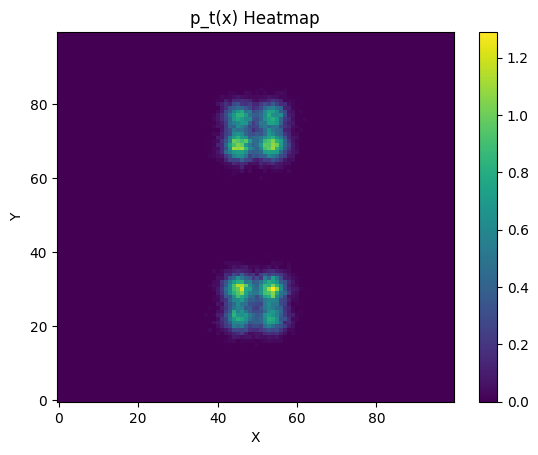

In [11]:
plt.imshow(L[5], origin='lower', aspect='auto')#extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar()  # Add a color bar to indicate the scale
plt.xlabel('X')  # Label for the x-axis
plt.ylabel('Y')  # Label for the y-axis
plt.title('p_t(x) Heatmap')  # Title of the heatmap
plt.show()  # Display the heatmap

## Train the model

In [4]:
for i in range(0, 100, 5):
    manager.train(nepochs = 5, print_progression=False)
    manager.evaluate()
manager.save('models/model.pt')
manager.save_eval_metrics('models/eval_model.pt')

 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.75it/s]

epoch_loss :-1.1158022284507751


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.83it/s]

epoch_loss :-1.1350258141756058


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.85it/s]

epoch_loss :-1.14754718542099


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.89it/s]

epoch_loss :-1.157952457666397


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


epoch_loss :-1.1625685542821884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 377.16it/s]


wasserstein
	losses_batch = -1.166934847831726
	wass = 0.24724538494274254
	precision = 0.36182625516031375
	recall = 0.9127666590693231
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.5182249774012823
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.92it/s]

epoch_loss :-1.1697364896535873


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.92it/s]

epoch_loss :-1.171704962849617


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.93it/s]

epoch_loss :-1.1793601214885712


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.92it/s]

epoch_loss :-1.1839739233255386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


epoch_loss :-1.184232160449028


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 384.52it/s]


wasserstein
	losses_batch = -1.1840004920959473
	wass = 0.19992657243771883
	precision = 0.5264652554115686
	recall = 0.9441663245305041
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.6759963161059457
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.88it/s]

epoch_loss :-1.1835781931877136


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.89it/s]

epoch_loss :-1.1915116608142853


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.1897035986185074


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.92it/s]

epoch_loss :-1.1905657052993774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


epoch_loss :-1.197718322277069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 372.59it/s]


wasserstein
	losses_batch = -1.2025096416473389
	wass = 0.19407226740601963
	precision = 0.533222640868414
	recall = 0.9379930597774111
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.6799263170331835
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.87it/s]

epoch_loss :-1.1981469839811325


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.90it/s]

epoch_loss :-1.202369436621666


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.93it/s]

epoch_loss :-1.1992579400539398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.91it/s]

epoch_loss :-1.2007450312376022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


epoch_loss :-1.2001334726810455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 371.09it/s]


wasserstein
	losses_batch = -1.1900140047073364
	wass = 0.155237169738127
	precision = 0.6439461932193576
	recall = 0.9512803212516241
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.7680079737862383
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.89it/s]

epoch_loss :-1.205944150686264


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.91it/s]

epoch_loss :-1.2076732069253922


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.81it/s]

epoch_loss :-1.206240475177765


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.80it/s]

epoch_loss :-1.2116923034191132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


epoch_loss :-1.2135950326919556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 366.60it/s]


wasserstein
	losses_batch = -1.2149384021759033
	wass = 0.14725089517065368
	precision = 0.6750556930164245
	recall = 0.9621691167664603
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.7934374510289977
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.89it/s]

epoch_loss :-1.2140066921710968


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.93it/s]

epoch_loss :-1.219333603978157


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.92it/s]

epoch_loss :-1.2141717970371246


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.88it/s]

epoch_loss :-1.2192165851593018


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


epoch_loss :-1.2152367532253265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 360.91it/s]


wasserstein
	losses_batch = -1.2183053493499756
	wass = 0.1470405790285124
	precision = 0.6946042410067271
	recall = 0.9567293275317268
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.8048625196752022
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.88it/s]

epoch_loss :-1.2134421318769455


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.86it/s]

epoch_loss :-1.2196184992790222


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:00<00:00,  3.11it/s]

epoch_loss :-1.216254100203514


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.81it/s]

epoch_loss :-1.2179359048604965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


epoch_loss :-1.2210406363010406


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 370.19it/s]


wasserstein
	losses_batch = -1.2204642295837402
	wass = 0.11179454505592415
	precision = 0.7772016150280825
	recall = 0.9695718414536
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.8627939682359056
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.88it/s]

epoch_loss :-1.223308339715004


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.90it/s]

epoch_loss :-1.2242056876420975


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.2249091267585754


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.91it/s]

epoch_loss :-1.2267488688230515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


epoch_loss :-1.2217301726341248


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 375.73it/s]


wasserstein
	losses_batch = -1.2231096029281616
	wass = 0.1319490642027543
	precision = 0.7716597354251485
	recall = 0.9671590115451606
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.858419163312288
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.92it/s]

epoch_loss :-1.2252970188856125


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.89it/s]

epoch_loss :-1.2225830405950546


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.228162944316864


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.91it/s]

epoch_loss :-1.2237017750740051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


epoch_loss :-1.2325005531311035


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 375.38it/s]


wasserstein
	losses_batch = -1.2485285997390747
	wass = 0.10186746321955496
	precision = 0.8096206452631306
	recall = 0.9755787182086691
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.8848856743988611
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.85it/s]

epoch_loss :-1.2307194471359253


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.93it/s]

epoch_loss :-1.2310233563184738


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.86it/s]

epoch_loss :-1.2308160215616226


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.85it/s]

epoch_loss :-1.226310208439827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


epoch_loss :-1.2324285805225372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 376.57it/s]


wasserstein
	losses_batch = -1.2348639965057373
	wass = 0.09430285615421427
	precision = 0.8179303065695663
	recall = 0.9747943241364975
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.8894994877927425
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.92it/s]

epoch_loss :-1.2293949574232101


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.92it/s]

epoch_loss :-1.2324610501527786


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.92it/s]

epoch_loss :-1.2301676273345947


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.93it/s]

epoch_loss :-1.2283284813165665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


epoch_loss :-1.2281538099050522


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 378.76it/s]


wasserstein
	losses_batch = -1.2260687351226807
	wass = 0.12422894274287223
	precision = 0.8286013638241125
	recall = 0.9703172718576489
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.8938772425342457
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.47it/s]

epoch_loss :-1.2328909188508987


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:00,  3.00it/s]

epoch_loss :-1.229092001914978


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.96it/s]

epoch_loss :-1.2339872419834137


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.92it/s]

epoch_loss :-1.23371222615242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


epoch_loss :-1.2328500300645828


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 385.48it/s]


wasserstein
	losses_batch = -1.2444616556167603
	wass = 0.07432587274142803
	precision = 0.8494582293165969
	recall = 0.9713720460415506
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.906333763673602
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.88it/s]

epoch_loss :-1.2351175397634506


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.90it/s]

epoch_loss :-1.2386227548122406


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.2342726439237595


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.91it/s]

epoch_loss :-1.2342568635940552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


epoch_loss :-1.2359152138233185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 378.75it/s]


wasserstein
	losses_batch = -1.2387559413909912
	wass = 0.08171247981119156
	precision = 0.8841171463144357
	recall = 0.9767653633258037
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9281349049912299
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.83it/s]

epoch_loss :-1.2398038357496262


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.87it/s]

epoch_loss :-1.2336759865283966


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:00<00:00,  3.18it/s]

epoch_loss :-1.2344270944595337


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  3.06it/s]

epoch_loss :-1.2396529763936996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


epoch_loss :-1.2329068034887314


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 381.69it/s]


wasserstein
	losses_batch = -1.2320160865783691
	wass = 0.13095599393282917
	precision = 0.849941891339446
	recall = 0.9805938460106264
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9106053174581692
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.72it/s]

epoch_loss :-1.2324811667203903


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.75it/s]

epoch_loss :-1.2371545881032944


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.77it/s]

epoch_loss :-1.2324413508176804


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.78it/s]

epoch_loss :-1.2372807711362839


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.77it/s]


epoch_loss :-1.2356413155794144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 362.83it/s]


wasserstein
	losses_batch = -1.2272928953170776
	wass = 0.08775277817364795
	precision = 0.8690224707829497
	recall = 0.9705157614359604
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9169692590944826
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.82it/s]

epoch_loss :-1.2393386214971542


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.89it/s]

epoch_loss :-1.241826593875885


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.89it/s]

epoch_loss :-1.2365231215953827


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.87it/s]

epoch_loss :-1.2386260777711868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


epoch_loss :-1.239407703280449


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 380.77it/s]


wasserstein
	losses_batch = -1.2379777431488037
	wass = 0.07200821349525452
	precision = 0.9252502872853876
	recall = 0.9857541482321355
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9545444185194124
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.95it/s]

epoch_loss :-1.2393907308578491


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.90it/s]

epoch_loss :-1.2390208691358566


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:00<00:00,  3.16it/s]

epoch_loss :-1.239690974354744


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  3.02it/s]

epoch_loss :-1.2396734803915024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


epoch_loss :-1.238381803035736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 381.30it/s]


wasserstein
	losses_batch = -1.2415660619735718
	wass = 0.048325376623750665
	precision = 0.9057688638697527
	recall = 0.987043520612647
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9446612834792885
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.79it/s]

epoch_loss :-1.2439492344856262


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.84it/s]

epoch_loss :-1.236030176281929


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.85it/s]

epoch_loss :-1.2417452335357666


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.84it/s]

epoch_loss :-1.24008347094059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


epoch_loss :-1.2369369715452194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 377.84it/s]


wasserstein
	losses_batch = -1.2361526489257812
	wass = 0.04660913775895055
	precision = 0.9263758487948006
	recall = 0.9783201240815675
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9516396823903227
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.91it/s]

epoch_loss :-1.244726151227951


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.89it/s]

epoch_loss :-1.238899827003479


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.2430450171232224


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.89it/s]

epoch_loss :-1.2435161918401718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


epoch_loss :-1.2402862161397934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 379.67it/s]


wasserstein
	losses_batch = -1.2439160346984863
	wass = 0.08204328893902899
	precision = 0.9205896264767772
	recall = 0.9796998515958609
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9492254004950215
	f_1_dc = 0.0
	fig = Figure(640x480)


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.84it/s]

epoch_loss :-1.241080179810524


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.88it/s]

epoch_loss :-1.239618495106697


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.2411766052246094


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.90it/s]

epoch_loss :-1.2413404434919357


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


epoch_loss :-1.2436246871948242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 378.94it/s]


wasserstein
	losses_batch = -1.2579057216644287
	wass = 0.060368339954337887
	precision = 0.9466502519014267
	recall = 0.9798429337652439
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9629606447340868
	f_1_dc = 0.0
	fig = Figure(640x480)


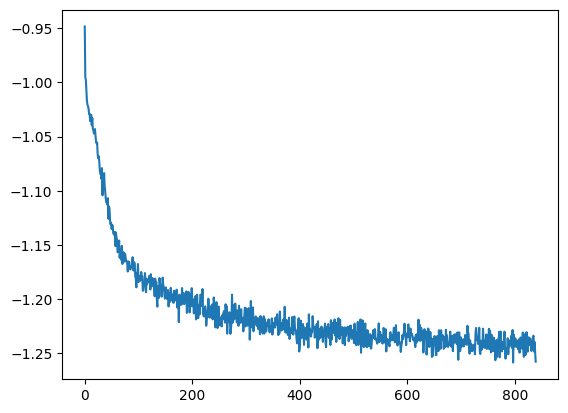

In [6]:
manager.display_evals('losses_batch', log_scale=False)

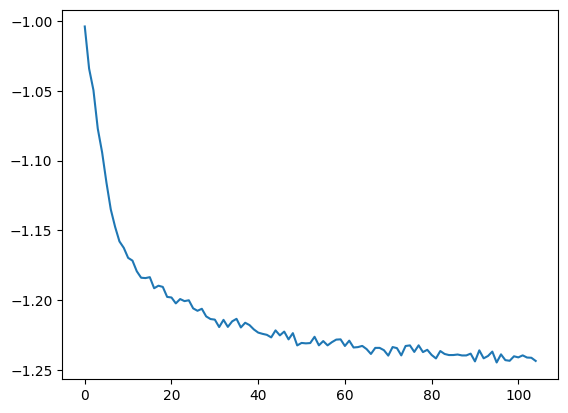

In [7]:
manager.display_evals('losses', log_scale=False)

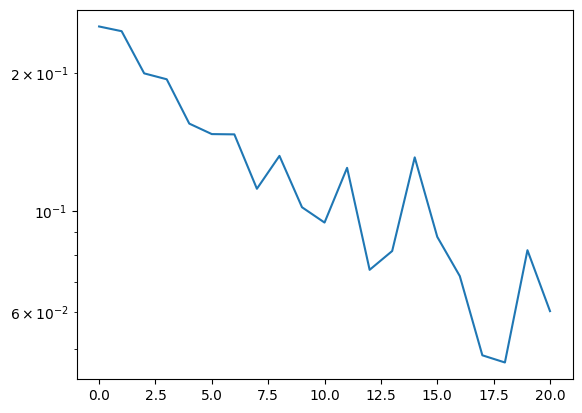

In [8]:
manager.display_evals('wass', log_scale=True)

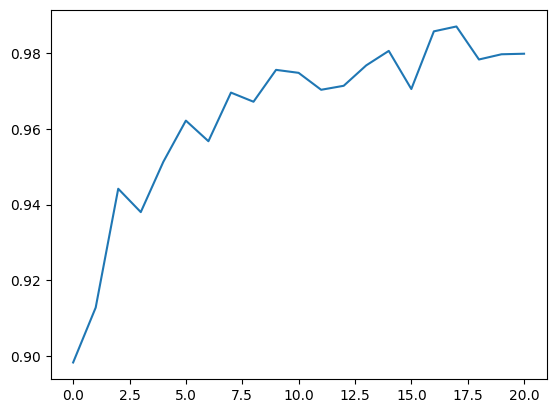

In [9]:
manager.display_evals('recall', log_scale=False)

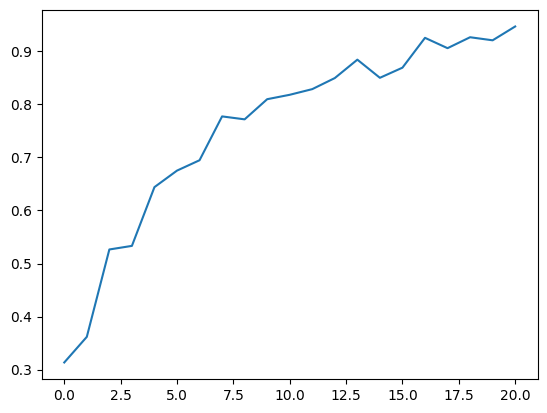

In [10]:
manager.display_evals('precision', log_scale=False)

As usual, $F_1$ score is:
$$ F_1 = 2\dfrac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}$$ 

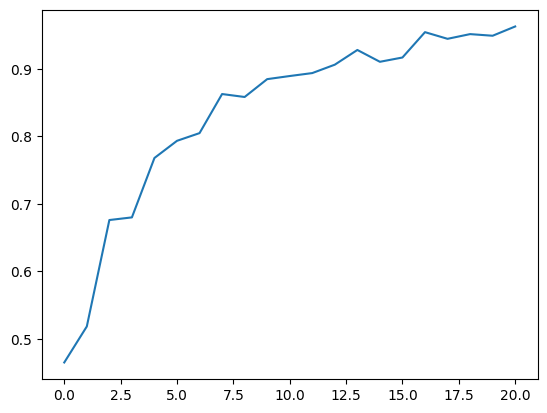

In [11]:
manager.display_evals('f_1_pr', log_scale=False)

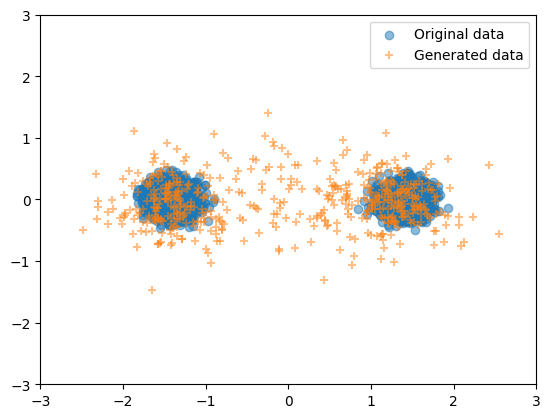

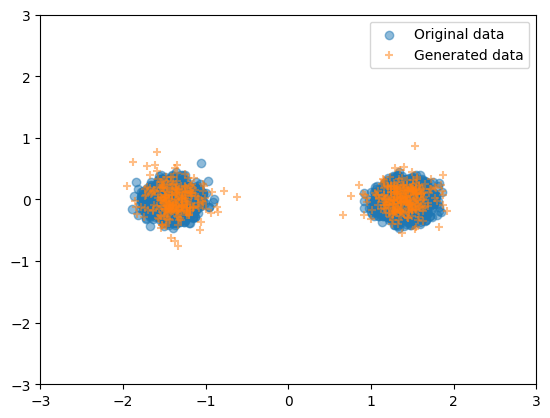

In [13]:
for i in [3, -1]:
    display(manager.eval.evals['fig'][i])

# Reverse Sampling

## Inspect generated data trajectory - from noise to data distribution

In [4]:
gen_model = Gen.GenerationManager(model, pdmp, data)
gen_model.generate(1000)

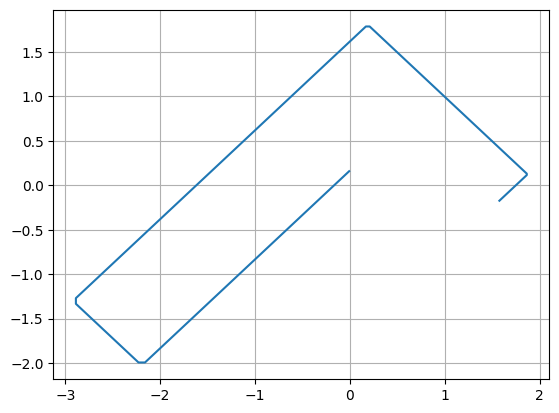

In [5]:
# Look at the position of the particle through time
pos = gen_model.history.squeeze(-2)[:, 0, :2] # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

* get animation

'./animation/check.mp4'

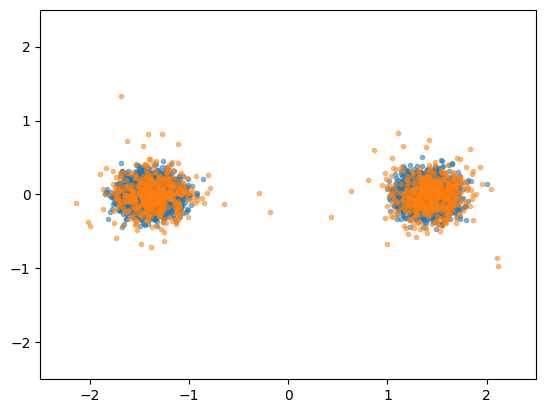

In [6]:
# Use Generation manager object to generate animation from the history of the data
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

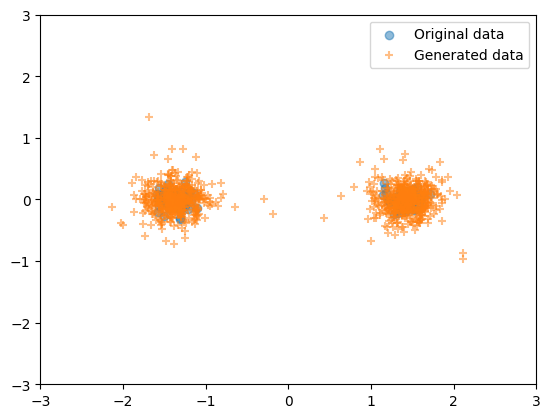

In [8]:
lims = 3
# gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 100, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))